<a href="https://colab.research.google.com/github/Temidayomichael/MSC_Binary-classification/blob/main/AUO_MSC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing the libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # for regex
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Load Dataset**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving endsars_combine.xlsx to endsars_combine (11).xlsx


In [3]:
import io
df = pd.read_excel(io.BytesIO(uploaded['endsars_combine.xlsx']))

In [4]:
df

,tweet,tag
0,"We’re with Nobody in the North, we’re alone, h...",0
1,I bet you without a good plan and calculated a...,0
2,Don’t End SARS #sars must stay #sars help #we ...,0
3,we need #sars to end bandits and kidnappers. ...,0
4,There's no different between Yahoo boys and ar...,0
...,...,...
195,One Nigeria One youth The sweet soundness of o...,1
196,The Nigerian government and their leaders need...,1
197,No matter the situation we go no we are still ...,1
198,Two party leadership I’ve always retained does...,1


# **Data preprocessing**

---

**Exploratory Data Analysis**

In [5]:
# checking for null values in the dataset
df.isnull().sum()

tweet    0
tag      0
dtype: int64

In [6]:
# Investigate all the elements whithin each Feature 

for column in df:
    unique_values = np.unique(df[column])
    nr_values = len(unique_values)
    if nr_values <= 10:
        print("The number of values for feature {} is: {} -- {}".format(column, nr_values, unique_values))
    else:
        print("The number of values for feature {} is: {}".format(column, nr_values))

The number of values for feature tweet is: 195
The number of values for feature tag is: 2 -- [0 1]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   200 non-null    object
 1   tag     200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


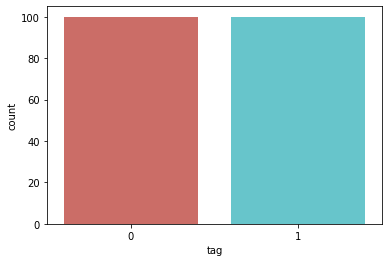

In [7]:
# Visualize the data using seaborn Pairplots, sjow
import seaborn as sns
g = sns.countplot(x='tag',data=df,palette='hls')
df.info()

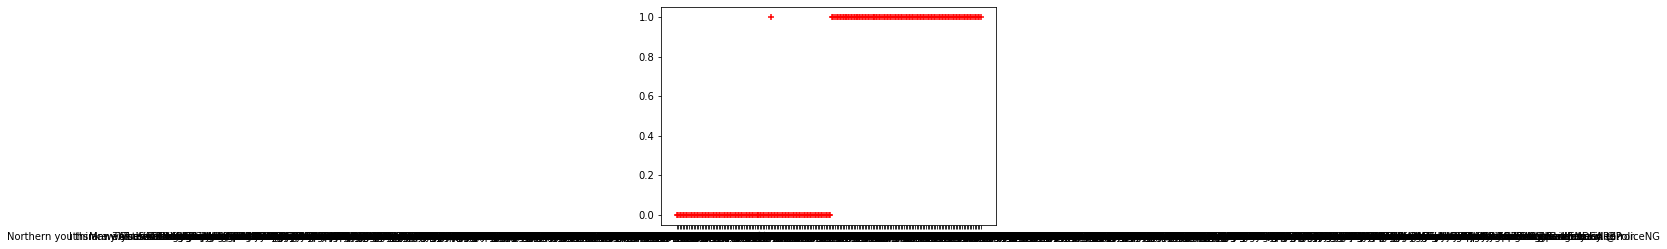

In [8]:
plt.scatter(df.tweet,df.tag,marker='+',color='red')

# *Data Cleaning*

In [9]:
#Clean the dataset

def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)
df['tweet'] = df['tweet'].apply(clean)
df.head()

,tweet,tag
0,"We’re with Nobody in the North, we’re alone, h...",0
1,I bet you without a good plan and calculated a...,0
2,Don’t End SARS #sars must stay #sars help #we ...,0
3,we need #sars to end bandits and kidnappers. ...,0
4,There's no different between Yahoo boys and ar...,0


In [10]:
# english stop words
import nltk
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
#check if dataset contains alphanumeric
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem
df.head()
df.tweet = df.tweet.apply(is_special)
df.head()

,tweet,tag
0,We re with Nobody in the North we re alone h...,0
1,I bet you without a good plan and calculated a...,0
2,Don t End SARS sars must stay sars help we ...,0
3,we need sars to end bandits and kidnappers ...,0
4,There s no different between Yahoo boys and ar...,0


In [12]:
#Change tweet column to lower
def to_lower(text):
    return text.lower()

df.tweet = df.tweet.apply(to_lower)
df.head()

,tweet,tag
0,we re with nobody in the north we re alone h...,0
1,i bet you without a good plan and calculated a...,0
2,don t end sars sars must stay sars help we ...,0
3,we need sars to end bandits and kidnappers ...,0
4,there s no different between yahoo boys and ar...,0


In [13]:
#Remove stopwords from dataset
from nltk.corpus import stopwords
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

df.tweet = df.tweet.apply(rem_stopwords)
df.head()

,tweet,tag
0,"[nobody, north, alone, problem, banditry, sars...",0
1,"[bet, without, good, plan, calculated, actions...",0
2,"[end, sars, sars, must, stay, sars, help, love...",0
3,"[need, sars, end, bandits, kidnappers, need, e...",0
4,"[different, yahoo, boys, armed, robbers, prote...",0


In [14]:
#Stematize the dataset
def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])
df.tweet = df.tweet.apply(stem_txt)
df.tweet[0]
df.head()

,tweet,tag
0,nobodi north alon problem banditri sar must st...,0
1,bet without good plan calcul action win scape ...,0
2,end sar sar must stay sar help love sar sar bl...,0
3,need sar end bandit kidnapp need endsar reform...,0
4,differ yahoo boy arm robber protest sar south ...,0


In [15]:
df.tag = df.tag.apply(str)
df.info() 
df = df.sample(frac=1).reset_index(drop=True)
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   200 non-null    object
 1   tag     200 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


,tweet,tag
0,fun celebr well also lend voic support endsar ...,1
1,movement end sar basic irrelev pls need get jo...,0
2,initi thought 1 week protest would meet endsar...,1
3,rather send kid abroad money meant fix school ...,1
4,sar scrap bad egg,0
...,...,...
195,think nigerian gov bring back sar,0
196,endsar protest most crimin kidnapp thug peopl ...,0
197,stop hypocrisi say hoodlum make clear endsarsp...,0
198,fellow onlin protest went street today peopl g...,1


In [16]:
#change dataset to integer
X = df['tweet'].values
y = df['tag'].values
cv = CountVectorizer()
X = cv.fit_transform(df.tweet).toarray()

In [17]:
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# **Build Model**

In [18]:
#Split dataset into test and training 

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=9)
print("Train shapes : X = {}, y = {}".format(X_train.shape,y_train.shape))
print("Test shapes : X = {}, y = {}".format(X_test.shape,y_test.shape))
Train_shapes: X
Test_shapes : X

Train shapes : X = (160, 1005), y = (160,)
Test shapes : X = (40, 1005), y = (40,)


In [19]:
# # K-Nearest Neighbors
# from sklearn.neighbors import KNeighborsClassifier
# KNearest = KNeighborsClassifier()
# KNearest.fit(X_train,y_train)
#     #test
# kn_test= KNearest.predict(X_test)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
Regression = LogisticRegression()
Regression.fit(X_train,y_train)
    #test
regres_test= Regression.predict(X_test)

# **Evaluate Model Performance**

In [20]:
# print("KNearest = ",accuracy_score(y_test,kn_test))
print("Regression = ",accuracy_score(y_test,regres_test))


KNearest =  0.775
Regression =  0.9


In [21]:
from scipy.special import expit, logit

In [22]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [30]:
print(classification_report(y_test,regres_test))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.86      1.00      0.93        25

    accuracy                           0.90        40
   macro avg       0.93      0.87      0.89        40
weighted avg       0.91      0.90      0.90        40



In [24]:
# cm=confusion_matrix(y_test,kn_test)
regres=confusion_matrix(y_test,regres_test)

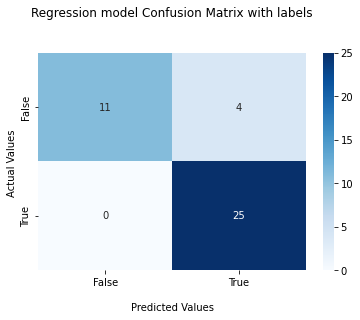

In [25]:
import seaborn as sns
ax = sns.heatmap(regres, annot=True, cmap='Blues')
ax.set_title('Regression model Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# import seaborn as sns
# ax = sns.heatmap(cm, annot=True, cmap='Blues')
# ax.set_title('KNN model Confusion Matrix with labels\n\n');
# ax.set_xlabel('\nPredicted Values')
# ax.set_ylabel('Actual Values ');
# ## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['False','True'])
# ax.yaxis.set_ticklabels(['False','True'])
# ## Display the visualization of the Confusion Matrix.
# plt.show()

In [ ]:
# filename = 'Knearest.sav'
# pickle.dump(KNearest, open(filename, 'wb'))
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.predict(X_test)
# print("KNearest = ",accuracy_score(y_test,result))
# print(result)

# **Export Model**

In [29]:
filename = './drive/MyDrive/regression.sav'
pickle.dump(Regression, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open('./drive/MyDrive/regression.sav', 'rb'))
result = loaded_model.predict(X_test)
print("Regression = ",accuracy_score(result,y_test))
print(result)

Regression =  0.9
['1' '0' '0' '1' '1' '1' '1' '0' '0' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '0' '0' '1' '1' '1' '0' '1' '1' '1' '1' '0' '1' '0' '1' '1' '1' '1' '1'
 '0' '1' '1' '0']
